# **IMPORTS**

In [30]:
! pip -q install transformers
import pandas as pd
import json
import os
import shutil
import numpy as np
import torch
torch.cuda.empty_cache()
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer, GPT2DoubleHeadsModel, GPT2LMHeadModel, GPT2Model,AutoModelForCausalLM, AutoTokenizer
from tqdm.notebook import tqdm
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')
drive.mount('/content/drive')
with open('/content/drive/MyDrive/personachat_self_original.json', "r", encoding="utf-8") as f:
    dataset = json.loads(f.read())
print(type(dataset))

"""df = pd.read_csv('/content/drive/MyDrive/dataset.csv')
df = df.dropna()
print("len df: ",len(df))
df = df.sample(frac=0.01, random_state=42)"""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'dict'>


'df = pd.read_csv(\'/content/drive/MyDrive/dataset.csv\')\ndf = df.dropna()\nprint("len df: ",len(df))\ndf = df.sample(frac=0.01, random_state=42)'

# **ARGS**

In [31]:
class Args():
    def __init__(self):
        self.output_dir = 'output'
        self.model_type = 'gpt2'
        self.model_name_or_path = 'microsoft/DialoGPT-medium'
        self.tokenizer_name = 'microsoft/DialoGPT-medium'
        self.batch_size = 4
        self.cache_dir = 'cached'
        self.do_train = True
        self.do_eval = True
        self.learning_rate = 2e-5
        self.weight_decay = 0.0
        self.adam_epsilon = 1e-8
        self.epochs = 1
        self.overwrite_output_dir = True
        self.seed = 42
        self.input_size = 128
        self.dataset_length = 10

    def set_mean_length(self, value):
        self.mean_length = value

args = Args()

# **PREPROCESSING**

In [43]:
tokenizer = GPT2Tokenizer.from_pretrained("microsoft/DialoGPT-medium")
#model = AutoModelForCausalLM.from_pretrained('/content/drive/MyDrive/modello/modello')
model = GPT2Model.from_pretrained('microsoft/DialoGPT-medium')
#tokenizer = AutoTokenizer.from_pretrained('microsoft/DialoGPT-medium')

special_tokens = ['<SP1>', '<SP2>', '<PAD>']
tokenizer.add_special_tokens({'additional_special_tokens': special_tokens})
special_ids = tokenizer.convert_tokens_to_ids([
        '<SP1>', '<SP2>', tokenizer.bos_token,
        tokenizer.eos_token,  '<PAD>'])

model.resize_token_embeddings(len(tokenizer))

def concat_input(input_ids1, input_ids2):
    return torch.cat((input_ids1, input_ids2), dim=0)

#INIZIO PROCESSING

def processing(datass):
  personality=[]
  utterances=[]
  for i in range(args.dataset_length): #4000 ---> length encoded_input_fake:  14737
    personality.append(dataset[datass][i]['personality'])
    utterances.append(dataset[datass][i]['utterances'])
  persona=[]
  history=[]
  spokerA=[]
  spokerB_real=[]
  spokerB_distract1=[]
  for i in range(len(personality)-1):
    for j in range(len(utterances[i])):
      candidate = utterances[i][j]['candidates']
      history1 = utterances[i][j]['history']
      persona.append(personality[i])
      history.append(history1)
      spokerA.append(history1[-1])
      spokerB_real.append(candidate[-1])
      spokerB_distract1.append(candidate[-2])


  def make_input(persona, spokerA, spokerB):
    input=[]
    for i in range(len(persona)):
      ids=[]

      spA='<SP1> '+spokerA[i]+tokenizer.eos_token
      spB='<SP2> '+spokerB[i]+tokenizer.eos_token
      ids.append(spA)
      ids.append(spB)
      input.append(ids)

    return input

  input1=make_input(persona,spokerA,spokerB_real)
  input_fake=make_input(persona,spokerA,spokerB_distract1)


  def unifica_coppie(array):
      nuovo_array = []
      for i in range(0, len(array)-1, 2):
          coppia1 = array[i]
          coppia2 = array[i+1]
          elemento_unificato = coppia1 + coppia2
          nuovo_array.append(elemento_unificato)
      return nuovo_array

  input2=unifica_coppie(input1)
  input2_fake=unifica_coppie(input_fake)



  def make_input_ids(input):
    encoded_input=[]
    for x in input:
      x=" ".join(x)
      x=tokenizer.encode(x)
      leng=len(x)
      x=x+tokenizer.encode('<PAD>')*(args.input_size-leng)
      encoded_input.append(x)
    return torch.tensor(encoded_input)

  encoded_input=make_input_ids(input2)
  print("len encoded_input: ",len(encoded_input))
  #print(encoded_input[0])
  encoded_input_fake=make_input_ids(input2_fake)
  print("len encoded_input_fake: ",len(encoded_input_fake))

  cls_label_R = torch.ones(size=(encoded_input.size(0),1), dtype=torch.long)
  cls_label_F1 = torch.zeros(size=(encoded_input_fake.size(0),1), dtype=torch.long)

  fin_input = concat_input(encoded_input, encoded_input_fake)
  fin_label = concat_input(cls_label_R , cls_label_F1)

  return fin_input, fin_label
#FINE PROCESSING

fin_input, fin_label=processing("train")

"""print(fin_input[0])
print(fin_label)
"""
#<PAD>[50259]
#<SP1> [50257]
#<SP2> [50258]
# eos 50256

print("bos token: ",tokenizer.eos_token)

def make_token_type_ids(input_str):
  x=0
  #input_str=input_str.view(-1)
  tok=[]
  for i in range(len(input_str)):
    if input_str[i]==50257:
      x=1
    if input_str[i]==50258:
      x=2
    if input_str[i]==50259:
      x=3
    tok.append(x)

  return torch.tensor(tok)

def make_LMlabel(input_ids):
    input=input_ids.squeeze()
    label=torch.zeros(size=input.size(), dtype=torch.long)
    for i in range(len(input)-1):
      label[i]=input[i+1]
    if input[len(input)-1] == 50259:
      label[len(input)-1]=50259
    else: label[len(input)-1]=50256

    return label.unsqueeze(0)

Some weights of the model checkpoint at microsoft/DialoGPT-medium were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


len encoded_input:  33
len encoded_input_fake:  33
bos token:  <|endoftext|>


# **DATALOADER**

In [44]:
#crea un dataset personalizzato per l'addestramento del modello, prende in input input_ids(identificatori di input)  e
#cls_label (etichette di classificazione)

class Custom_Dataset(Dataset):
  def __init__(self, input_ids,cls_label):
    self.input_ids = input_ids
    self.cls_label = cls_label
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    input_ids = self.input_ids[idx]
    token_type_ids = make_token_type_ids(self.input_ids[idx])
    LM_label = make_LMlabel(self.input_ids[idx])
    cls_label = self.cls_label[idx]

    return input_ids, token_type_ids, LM_label, cls_label

chat_dataset = Custom_Dataset(fin_input, fin_label)

print(len(chat_dataset))

batch_size=args.batch_size
dataloader = DataLoader(chat_dataset, batch_size=batch_size, shuffle=True,drop_last=True)

66


# **MODEL**

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: {}".format(device))
class chatbot_model(nn.Module):
  def __init__(self):
    super(chatbot_model, self).__init__()
    self.model = model
    self.drop = nn.Dropout(0.2)
    self.CL = nn.Linear(1024*2,1)
    self.LM = nn.Linear(1024,50260) #output del language modeling (con funzione di attivazione softmax) restituisce un tensore
    # con dimensione finale 50250 che è il numero di token nel vocabolario per il language modeling(si restituisce quello con prob. maggiore)

  def forward(self, input,token):
    out = self.model(input,token_type_ids= token) #tensore che rappresenta le rappresentazioni latenti delle parole di input
    x = out[0]
    x = self.drop(x)
    avgv=torch.mean(x,1)
    maxv,_=torch.max(x,1)
    clss=torch.cat((avgv,maxv),1)
    clss = self.CL(clss) #fornisce un valore di output che ci da la probabilità che la risposta generata sia un distrattore o sia corretta
    x = self.LM(x)
    return x, clss

chatbot=chatbot_model() #model
chatbot=chatbot.to(device)

Device: cuda


# **TRAIN**

In [39]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('always')

def train_one_epoch(data_loader, model, optimizer, device,epochs):

  model.train()
  #tk0 = tqdm(data_loader, total=len(data_loader))#barra di avanzamento durante le iterazioni del training
  total_loss = 0.0
  lm_loss_values = []
  cls_loss_values = []
  total_loss1 = []
  print("Lunghezza dataset train: ",len(data_loader))
  for batch in tqdm(data_loader, desc="Training"):#iterazioni attraverso data_loader
      input_ids, token_type_ids, LM_label, CLS_label = batch #estrae i tensori di input dal batch
      input_ids = input_ids.to(device, dtype=torch.long) #id degli input
      token_type_ids = token_type_ids.to(device, dtype=torch.long)
      LM_label = LM_label.to(device, dtype=torch.long)
      CLS_label = CLS_label.to(device, dtype=torch.float) #etichette per l'addestramento del modello di classificazione

      model.zero_grad() #azzeramento dei gradienti prima di eseguire il passaggio all'indietro per evitare che si accumulino
      LM_logits, CLS_logits = model(input_ids, token_type_ids) #esegue il forward del modello e restituisce i logits per il LM e il CLS
      LM_logits = LM_logits.view(-1, 50260)
      LM_label = LM_label.view(-1)
      #loss_LM = nn.CrossEntropyLoss()(LM_logits, LM_label) #loss del modello di linguaggio
      loss_LM=loss_LM = nn.CrossEntropyLoss()(LM_logits, LM_label)
      loss_CLS = nn.BCEWithLogitsLoss()(CLS_logits, CLS_label)*2 #loss per la classificazione
      lm_loss_values.append(loss_LM.item())
      cls_loss_values.append(loss_CLS.item())
      #BCEWithLogitsLoss funzione di loss comunemente usata per problemi di classificazione binaria, questa loss combina la funzione sigmoide
      #e la loss di entropia binaria. Accetta due parametri,  i logits predetti e le etichette reali. I logits sono i valori di output prodotti
      # prima dell'attivazione, le etichette reali sono valori binari (0,1) che indicano le classi di riferimento per l'addestramento

      loss = loss_LM + loss_CLS #calcolo della loss totale combinando le due loss
      total_loss1.append(loss.item())
      total_loss += loss.item() #aggiunge il valore della loss totale al valore accumulato
      
      #per entrambe le loss esegui il passaggio all'indietro per calcolare i gradienti rispetto ai pesi del modello
      loss_LM.backward(retain_graph=True)
      loss_CLS.backward()
      optimizer.step() #aggiorna i pesi del modello in modo da ridurre la loss
      optimizer.zero_grad() #azzeramento dei gradienti

  print(f"loss:{loss}")

  avg_train_loss = total_loss / len(data_loader)
  print(" Average training loss: {0:.2f}".format(avg_train_loss))

  plt.figure(figsize=(8, 4))
  plt.plot(lm_loss_values, label="LM Loss")
  plt.plot(cls_loss_values, label="CLS Loss")
  plt.xlabel("Iterations(batch)")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

  plt.figure(figsize=(8, 4))
  plt.plot(total_loss1, label="Total Loss")
  plt.xlabel("Iterations(batch)")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()


#funzione fit per addestrare il modello
def fit(train_dataloader, EPOCHS=args.epochs):
  #optimizer = torch.optim.AdamW(chatbot.parameters(),lr=lr) #optimizer

  lr = args.learning_rate
  no_decay = ["bias", "LayerNorm.weight"]#parametri dei modelli che non devono essere soggetti a decay durante la discesa del gradiente.
  # raggruppa i parametri del modello in base a se necessitano o meno di weight decay.
  #il weight decay è una tecnica di regolarizzazione utilizzata per prevenire l'overfitting del modello durante l'addestramento.
  #consiste nell'aggiungere una penalità alla funzione di loss in base alla norma L2 dei pesi del modello.
  optimizer_grouped_parameters = [
      {
          "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
          "weight_decay": args.weight_decay,
      },
      {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
  ]
  optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=lr, eps=args.adam_epsilon)#algoritmo di ottimizzazione basato su Adam che applica weight decay solo sui parametri che richiedono l'applicazione di questo tipo di regolarizzazione.
  # definisce uno scheduler di tipo lineare con warmup, che aumenta gradualmente il tasso di apprendimento nei primi num_warmup_steps passi di addestramento e lo riduce linearmente fino a 0 in corrispondenza dell'ultimo passo.

  for i in range(EPOCHS):
    print(f"EPOCH:{i+1}/",EPOCHS)
    print('TRAIN')
    train_one_epoch(train_dataloader, chatbot, optimizer, device,EPOCHS)

    import os
    # Verifica se il file esiste
    if os.path.exists("output.pt"):
        # Elimina il file
        os.remove("output.pt")
        print("Il file è stato eliminato con successo ed è stato salvato il modello aggiornato.")
    else:
        print("Il file non esiste.")
    torch.save(chatbot ,"output.pt") #dopo aver completato n epoche, il modello viene salvato


# **TESTING**

In [56]:
def eval():
  fin_input_test, fin_label_test=processing("valid")
  chat_dataset_test = Custom_Dataset(fin_input_test, fin_label_test)
  print("Lunghezza dataset test",len(chat_dataset_test))

  batch_size_test=args.batch_size
  dataloader_test = DataLoader(chat_dataset_test, batch_size=batch_size_test, shuffle=True,drop_last=True)
  print("Lunghezza dataset test",len(dataloader_test))
  chatbot.eval()
  eval_loss = 0.0
  nb_eval_steps = 0
  total_loss1 = []
  total_loss = 0.0


  for batch in tqdm(dataloader_test, desc="Evaluating"):#iterazioni attraverso data_loader
      input_ids, token_type_ids, LM_label, CLS_label = batch #estrae i tensori di input dal batch
      input_ids = input_ids.to(device, dtype=torch.long) #id degli inputFlen enc
      token_type_ids = token_type_ids.to(device, dtype=torch.long)
      LM_label = LM_label.to(device, dtype=torch.long)
      CLS_label = CLS_label.to(device, dtype=torch.float) #etichette per l'addestramento del modello di classificazione

      with torch.no_grad():#disabilita il calcolo e l'accumulo del gradiente durante la fase di backward propagation del modello

        LM_logits, CLS_logits = chatbot(input_ids, token_type_ids) #esegue il forward del modello e restituisce i logits per il LM e il CLS
        LM_logits = LM_logits.view(-1, 50260)
        LM_label = LM_label.view(-1)
        #loss_LM = nn.CrossEntropyLoss()(LM_logits, LM_label) #loss del modello di linguaggio
        loss_LM=loss_LM = nn.CrossEntropyLoss()(LM_logits, LM_label)
        loss_CLS = nn.BCEWithLogitsLoss()(CLS_logits, CLS_label)*2 #loss per la classificazione
        #BCEWithLogitsLoss funzione di loss comunemente usata per problemi di classificazione binaria, questa loss combina la funzione sigmoide
        #e la loss di entropia binaria. Accetta due parametri,  i logits predetti e le etichette reali. I logits sono i valori di output prodotti
        # prima dell'attivazione, le etichette reali sono valori binari (0,1) che indicano le classi di riferimento per l'addestramento

        loss = loss_LM + loss_CLS #calcolo della loss totale combinando le due loss
        total_loss1.append(loss.item())
        total_loss += loss.item()

      nb_eval_steps += 1
  test_loss=total_loss/nb_eval_steps
  perplexity = torch.exp(torch.tensor(eval_loss))
  result = {"perplexity": perplexity.item()}
  return result

# **START TRAINING**

In [54]:
import warnings
warnings.filterwarnings('ignore')
#fit(dataloader)
def main():
  fit(dataloader)

  if args.do_eval:
        print("##Start evaluation##")
        result = eval()
        print("Testing results: ",result)

# **MAIN**

EPOCH:1/ 1
TRAIN
Lunghezza dataset train:  16


Training: 100%|██████████| 16/16 [00:09<00:00,  1.67it/s]


loss:6.420151233673096
 Average training loss: 6.50


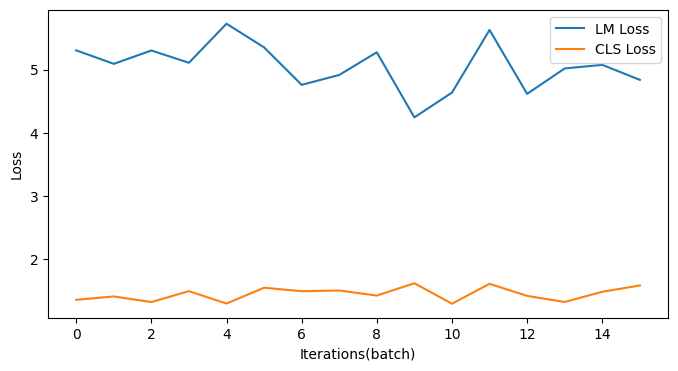

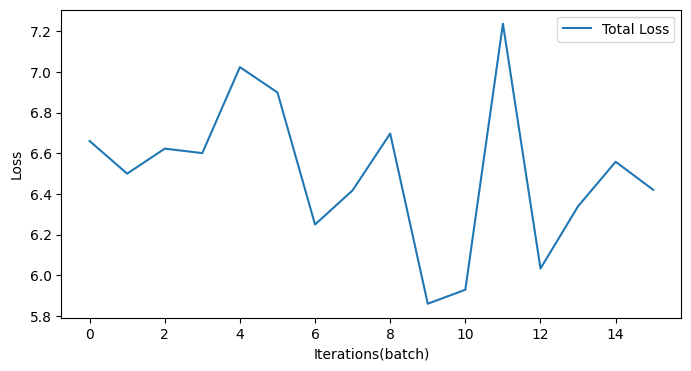

Il file è stato eliminato con successo ed è stato salvato il modello aggiornato.
##Start evaluation##
len encoded_input:  33
len encoded_input_fake:  33
Lunghezza dataset test 66
Lunghezza dataset test 16


Evaluating: 100%|██████████| 16/16 [00:02<00:00,  7.09it/s]


Testing results:  {'perplexity': 1.0}


In [57]:
import warnings
warnings.filterwarnings('ignore')
main()

# **POSTPROCESSING**

In [ ]:
# implementazione del cahtbbot per generare risposte in base alla personaliotà e alla cronologia della conversazione fornite
# il chatbot genera testo telezionando i token successivi in base alle probabilità predette dal modello, viene anche
# calcolata una previsione di classificaizone binaria per valutare la coerenza delle risposte generate
# l'interazione avviene attraverso la funzione interact

#<PAD>[50259]
#<SP1> [50257]
#<SP2> [50258]
# eos 50256

def make_input_chat(input): #prende una lista di input e li converte in formato adatto all'interazione con il chatbot
  input_ids = []
  ids = []
  for j in range(len(input)):
      ids += tokenizer.encode(input[j])
  ids = ids+[50258]
  input_ids.append(ids)
  return torch.tensor(input_ids)

def choose_from_top(probs, n=5): #restituisce l'indice del token successivo selezionato casualmente dai primi n token
    ind = np.argpartition(probs, -n)[-n:]
    top_prob = probs[ind]
    top_prob = top_prob / np.sum(top_prob) # Normalize
    choice = np.random.choice(n, 1, p = top_prob)
    token_id = ind[choice][0]
    return int(token_id)

def find_num(aa,num): #restituisce il numero di occorrenze del numero (num) all'interno del tensore (aa), serve per contare il numero di
                      #occorrenze di token speciali
  s=0
  for i in range(len(aa.view(-1))):
    aa=aa.view(-1)
    #print(aa.cpu().detach().numpy().tolist()[i])

    if (aa.cpu().detach().numpy().tolist()[i]) == (num):

      s=s+1

  return s

def generate_text(hidden_input, token_types, model):
    current_hidden = hidden_input
    sequence_length = (current_hidden.size(-1))
    model.eval()
    with torch.no_grad():
        while count_tokens(current_hidden, 50259) < 1:
            outputs = model(current_hidden, token_types)
            hidden_logits, class_logits = outputs
            softmax_logits = torch.softmax(hidden_logits[0, -1], dim=0)
            next_token_id = choose_from_top(softmax_logits.to('cpu').numpy(), n=3)

            if next_token_id == 50259:
                token_types = torch.cat([token_types, torch.ones((1, 1)).long().to(device) * 2], dim=1)
            else:
                if count_tokens(current_hidden, 50258) > count_tokens(current_hidden, 50257):
                    if next_token_id == 50258:
                        next_token_id = 50257
                        token_types = torch.cat([token_types, torch.ones((1, 1)).long().to(device) * 1], dim=1)
                    else:
                        token_types = torch.cat([token_types, torch.ones((1, 1)).long().to(device) * 2], dim=1)
                elif count_tokens(current_hidden, 50258) <= count_tokens(current_hidden, 50257):
                    if next_token_id == 50257:
                        next_token_id = 50258
                        token_types = torch.cat([token_types, torch.ones((1, 1)).long().to(device) * 2], dim=1)
                    else:
                        token_types = torch.cat([token_types, torch.ones(1, 1).long().to(device) * 1], dim=1)

            current_hidden = torch.cat([current_hidden, torch.ones((1, 1)).long().to(device) * next_token_id], dim=1)

            if current_hidden.size(-1) - sequence_length > 30:
                break

        output_list = list(current_hidden.squeeze().to('cpu').numpy())
        output_text = tokenizer.decode(output_list)

    return output_text, current_hidden, token_types, sequence_length

def cls_text(cur_ids, token_type_ids, model, list_cls): #calcoal la previsione di classificazione binaria del modello
    #per il testo generato fino a quel punto, calcola le previsioni utilizzando il modello e la funzione di attivazione sigmoidale

    model.eval()
    with torch.no_grad():
      _, cls_outputs = model(cur_ids, token_type_ids)
      cls = nn.Sigmoid()(cls_outputs)
      list_cls.append(cls)

    return list_cls

def chat(history, tokenizer, model=chatbot, num=3): # gestisce l'intera conversazione
    #una cronologia, un tokenizer e un modello di chatbot. Prepara l'input concatenando queste cose, quindi chiama make_input_chat e
    # make_token_type_ids per ottenere i tensori di input e i toke di tipo. Utilizza il modello per generare testi e calcola le previsioni
    # di classificazione per ognuno di essi, restituisce il testo generato con la previsione di CLS più alta.

  #input_str
  speechs = []
  list_cls = []
  input=[]
  for k in range(len(history)):
      if k % 2 ==0:
        input.append('<SP1> '+history[k])
      else: input.append('<SP2> '+history[k])

  print("input: ",input)
  input_str = make_input_chat(input)
  input_str2=input_str.view(-1)
  token_type_ids = make_token_type_ids(input_str2)
  input_str = input_str.to(device)
  token_type_ids = token_type_ids.view(1,-1).to(device)

  for i in range(num):
    o, c, t, l = generate_text(input_str,token_type_ids, chatbot)
    speechs.append(o)
    list_cls = cls_text(c, t, chatbot, list_cls)

  print("speechs: ",speechs)
  """print(type(list_cls))
  print(type(list_cls[0]))
  print(len(list_cls))
  print(list_cls[0])"""
  list_cls = np.array([tensor.item() for tensor in list_cls])
  idx = np.argmax(list_cls)
  speech = speechs[idx]

  return speech, l

def interact(model): # permette l'interazione dell utente con il chatbot
  history = []
  step=0
  #chatbo=chatbot_model()
  #chatbo=chatbo.to(device)
  #model = torch.load("output/model.pt")
  chatting=True
  while chatting:
        raw_text = input(">>>You: ")
        while not raw_text:
            print('Prompt should not be empty!')
            raw_text = input(">>>You ")
        if raw_text.lower().strip() in ['bye','quit','exit']:
          print(">>Bot: See you soon!")
          step=0
          chatting=False
        else:

          if step>=2:
            history = history[2:]
          history.append(raw_text)
          print("History: ",history)
          with torch.no_grad():
              out_ids, l = chat(history, tokenizer, model)
              print("Out_ids: ",out_ids)
              print("l: ",l)
          out = tokenizer.encode(out_ids)
          spoker = out[l:]
          out_text = tokenizer.decode(out, skip_special_tokens=True)
          spoker_text = tokenizer.decode(spoker, skip_special_tokens=True)
          history.append(spoker_text)
          print("History after append(spoker_text): ",history)

          #print(out_text)
          print(">>>Chatbot: ",spoker_text)
          step+=1

#interact(personal, chatbot)

# **INTERACTION**

In [ ]:
import warnings
warnings.filterwarnings("ignore")
#model2 = torch.load("/content/drive/MyDrive/transfo/transfer_outputmodel_1.pt")
#chatbot=model2
interact(chatbot)
#<PAD>[50259]
#<SP1> [50257]
#<SP2> [50258]
# eos 50256